In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from torch import linalg as LA

In [3]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time, random
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot,setup_seed
from utils import confusion_matrix,metrics_scores,pff

setup_seed(3047)

from model import FixCapsNet

In [4]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "NCT_CRC"#HAM_Matrix# ten categores
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}


try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# normalize = transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
Resize = transforms.Resize((225,300))

def get_data(trans='302'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    vt = int(trans)
    data_transform = {
        "train": transforms.Compose([Resize,
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     normalize]),
        "val": transforms.Compose([Resize,
                                   transforms.ToTensor(),
                                   normalize]),
        "test": transforms.Compose([Resize,
                                    transforms.ToTensor(),
                                    normalize]),
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "datasets")#, "COVID_19")#ham11,HAM10000
    # image_path = os.path.join(data_root, "ImageNet")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [6]:
BatchSize = 168
V_size = 32
T_size = 32

sub_dirs = "NCT_CRC"
train_doc = f"{sub_dirs}/train"
val_doc = f"{sub_dirs}/val" 
test_doc = f"{sub_dirs}/test" 


nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()
print(f'Using {n_classes} classes.')

Using 6 dataloader workers every process.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
Using 9 classes.


In [7]:
# Code: https://github.com/Woodman718/FixCaps
n_channels = 3 #RGB

network = FixCapsNet(conv_inputs=n_channels, 
                     num_classes=n_classes,# category_number
                     init_weights=True,)
network = network.to(device)

In [8]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [9]:
# img_size = 299
# summary(network,(n_channels,225,300))

In [10]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(21, 21), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [11]:
dsize = (1, 3, 225, 300)
# mode='DS'
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps",model=network,inputes=input_data)

  Model   | Params(M) | FLOPs(G) | FPS
----------|-----------|----------|-----
FixCaps |    1.41   |   2.74   | 105.4


In [12]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        # v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        # v_mag = torch.norm(output,p=2,dim=(2,3), keepdim=True)
        v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#‘fro’ (default)
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 90: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [13]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            # v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            # output = rearrange(output, 'b c (g h) w -> b c g (h w)',g=4)
            # v_mag = torch.norm(output,p=2,dim=(2,3), keepdim=True)
            v_mag = LA.norm(output,ord='nuc',dim=(2,3), keepdim=True)#
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), test_path)
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [14]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    !mkdir -p ./tmp/{img_title}/{suf} 
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth' #training
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth' #validation
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth' #training
test_path = f'./tmp/{img_title}/{suf}/test_best_{img_title}_{suf}.pth' #testing
print(save_PATH)

suf:0114_110927
./tmp/NCT_CRC/0114_110927/best_NCT_CRC_0114_110927.pth


In [15]:
num_epochs= 108

In [16]:
# network.load_state_dict(torch.load(last_path))
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')
    
print('Finished Training')

[Train Epoch:[1]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.23928,ACC:0.44583
[476/477] Loss0.18978,ACC:0.55391
Train Epoch:[1] Loss:0.27345,Acc:0.55425,Best_train:0.55425
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:81.772%
Best_val:[81.772%]
[Train Epoch:[2]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.09121,ACC:0.75040
[476/477] Loss0.13960,ACC:0.78205
Train Epoch:[2] Loss:0.14826,Acc:0.78206,Best_train:0.78206
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:69.213%
Best_val:[81.772%]
[Train Epoch:[3]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.10473,ACC:0.83756
[476/477] Loss0.14469,ACC:0.85183
Train Epoch:[3] Loss:0.10839,Acc:0.85186,Best_train:0.85186
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:95.342%
Best_val:[95.342%]
[Train Epoch:[4]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.05827,ACC:0.88851
[476/477] Loss0.07669,ACC:0.89349
Train Epoch:[4] Loss:0.08090,Acc:0.89352,Best_train:0.89352
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.848%
Best_val:[98.848%]
[Train Epoch:[5]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.06294,ACC:0.91309
[476/477] Loss0.06511,ACC:0.91485
Train Epoch:[5] Loss:0.06585,Acc:0.91485,Best_train:0.91485
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.293%
Best_val:[99.293%]
[Train Epoch:[6]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.05562,ACC:0.91797
[476/477] Loss0.05565,ACC:0.91760
Train Epoch:[6] Loss:0.06349,Acc:0.91756,Best_train:0.91756
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.232%
Best_val:[99.293%]
[Train Epoch:[7]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.05887,ACC:0.91977
[476/477] Loss0.05397,ACC:0.92017
Train Epoch:[7] Loss:0.06218,Acc:0.92018,Best_train:0.92018
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.404%
Best_val:[99.404%]
[Train Epoch:[8]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.07286,ACC:0.91196
[476/477] Loss0.07659,ACC:0.91610
Train Epoch:[8] Loss:0.06501,Acc:0.91608,Best_train:0.92018
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.151%
Best_val:[99.404%]
[Train Epoch:[9]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.07011,ACC:0.89951
[476/477] Loss0.06050,ACC:0.91079
Train Epoch:[9] Loss:0.06807,Acc:0.91076,Best_train:0.92018
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.05%
Best_val:[99.404%]
[Train Epoch:[10]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.04267,ACC:0.90974
[476/477] Loss0.05082,ACC:0.91742
Train Epoch:[10] Loss:0.06370,Acc:0.91740,Best_train:0.92018
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.363%
Best_val:[99.404%]
[Train Epoch:[11]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.08018,ACC:0.93115
[476/477] Loss0.06707,ACC:0.92945
Train Epoch:[11] Loss:0.05561,Acc:0.92946,Best_train:0.92946
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:93.756%
Best_val:[99.404%]
[Train Epoch:[12]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.07335,ACC:0.93552
[476/477] Loss0.05476,ACC:0.93848
Train Epoch:[12] Loss:0.04876,Acc:0.93856,Best_train:0.93856
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.636%
Best_val:[99.636%]
[Train Epoch:[13]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.06092,ACC:0.94780
[476/477] Loss0.02819,ACC:0.94717
Train Epoch:[13] Loss:0.04186,Acc:0.94721,Best_train:0.94721
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.333%
Best_val:[99.636%]
[Train Epoch:[14]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.04062,ACC:0.95726
[476/477] Loss0.04722,ACC:0.95813
Train Epoch:[14] Loss:0.03373,Acc:0.95818,Best_train:0.95818
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.414%
Best_val:[99.636%]
[Train Epoch:[15]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02767,ACC:0.96606
[476/477] Loss0.01881,ACC:0.96545
Train Epoch:[15] Loss:0.02897,Acc:0.96543,Best_train:0.96543
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.586%
Best_val:[99.636%]
[Train Epoch:[16]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02489,ACC:0.96559
[476/477] Loss0.01979,ACC:0.96626
Train Epoch:[16] Loss:0.02790,Acc:0.96625,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.677%
Best_val:[99.677%]
[Train Epoch:[17]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03961,ACC:0.96699
[476/477] Loss0.02221,ACC:0.96596
Train Epoch:[17] Loss:0.02814,Acc:0.96598,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.545%
Best_val:[99.677%]
[Train Epoch:[18]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02926,ACC:0.95921
[476/477] Loss0.02404,ACC:0.95892
Train Epoch:[18] Loss:0.03277,Acc:0.95888,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:78.731%
Best_val:[99.677%]
[Train Epoch:[19]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02736,ACC:0.95168
[476/477] Loss0.04846,ACC:0.95278
Train Epoch:[19] Loss:0.03787,Acc:0.95274,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:89.239%
Best_val:[99.677%]
[Train Epoch:[20]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03502,ACC:0.94833
[476/477] Loss0.05185,ACC:0.94745
Train Epoch:[20] Loss:0.04144,Acc:0.94740,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:96.908%
Best_val:[99.677%]
[Train Epoch:[21]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02637,ACC:0.94885
[476/477] Loss0.04181,ACC:0.94950
Train Epoch:[21] Loss:0.03976,Acc:0.94949,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.343%
Best_val:[99.677%]
[Train Epoch:[22]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01855,ACC:0.95941
[476/477] Loss0.02976,ACC:0.95671
Train Epoch:[22] Loss:0.03488,Acc:0.95672,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.626%
Best_val:[99.677%]
[Train Epoch:[23]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03271,ACC:0.96469
[476/477] Loss0.02315,ACC:0.96392
Train Epoch:[23] Loss:0.02924,Acc:0.96391,Best_train:0.96625
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:94.978%
Best_val:[99.677%]
[Train Epoch:[24]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01723,ACC:0.96984
[476/477] Loss0.02097,ACC:0.97003
Train Epoch:[24] Loss:0.02450,Acc:0.97005,Best_train:0.97005
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.626%
Best_val:[99.677%]
[Train Epoch:[25]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02149,ACC:0.97459
[476/477] Loss0.02714,ACC:0.97469
Train Epoch:[25] Loss:0.02125,Acc:0.97472,Best_train:0.97472
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.737%
Best_val:[99.737%]
[Train Epoch:[26]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02919,ACC:0.97461
[476/477] Loss0.01314,ACC:0.97454
Train Epoch:[26] Loss:0.02059,Acc:0.97452,Best_train:0.97472
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.707%
Best_val:[99.737%]
[Train Epoch:[27]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02065,ACC:0.97609
[476/477] Loss0.00832,ACC:0.97570
Train Epoch:[27] Loss:0.02063,Acc:0.97566,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.838%
Best_val:[99.838%]
[Train Epoch:[28]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02504,ACC:0.97024
[476/477] Loss0.03050,ACC:0.97050
Train Epoch:[28] Loss:0.02430,Acc:0.97054,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.636%
Best_val:[99.838%]
[Train Epoch:[29]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01310,ACC:0.96414
[476/477] Loss0.01180,ACC:0.96456
Train Epoch:[29] Loss:0.02889,Acc:0.96459,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.727%
Best_val:[99.838%]
[Train Epoch:[30]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03691,ACC:0.95708
[476/477] Loss0.02945,ACC:0.95609
Train Epoch:[30] Loss:0.03488,Acc:0.95605,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:89.158%
Best_val:[99.838%]
[Train Epoch:[31]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03527,ACC:0.95966
[476/477] Loss0.03877,ACC:0.96143
Train Epoch:[31] Loss:0.03086,Acc:0.96149,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.434%
Best_val:[99.838%]
[Train Epoch:[32]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02056,ACC:0.96634
[476/477] Loss0.02760,ACC:0.96512
Train Epoch:[32] Loss:0.02812,Acc:0.96510,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.374%
Best_val:[99.838%]
[Train Epoch:[33]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02693,ACC:0.96994
[476/477] Loss0.03110,ACC:0.97020
Train Epoch:[33] Loss:0.02423,Acc:0.97017,Best_train:0.97566
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.566%
Best_val:[99.838%]
[Train Epoch:[34]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01756,ACC:0.97619
[476/477] Loss0.01759,ACC:0.97663
Train Epoch:[34] Loss:0.01983,Acc:0.97663,Best_train:0.97663
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.485%
Best_val:[99.838%]
[Train Epoch:[35]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01087,ACC:0.98009
[476/477] Loss0.03632,ACC:0.97995
Train Epoch:[35] Loss:0.01704,Acc:0.97998,Best_train:0.97998
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.626%
Best_val:[99.838%]
[Train Epoch:[36]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01600,ACC:0.98182
[476/477] Loss0.02567,ACC:0.98139
Train Epoch:[36] Loss:0.01618,Acc:0.98141,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.606%
Best_val:[99.838%]
[Train Epoch:[37]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01217,ACC:0.98032
[476/477] Loss0.01929,ACC:0.98032
Train Epoch:[37] Loss:0.01667,Acc:0.98033,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.707%
Best_val:[99.838%]
[Train Epoch:[38]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01976,ACC:0.97594
[476/477] Loss0.01822,ACC:0.97624
Train Epoch:[38] Loss:0.01960,Acc:0.97624,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.495%
Best_val:[99.838%]
[Train Epoch:[39]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03049,ACC:0.96931
[476/477] Loss0.02041,ACC:0.96958
Train Epoch:[39] Loss:0.02493,Acc:0.96958,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.424%
Best_val:[99.838%]
[Train Epoch:[40]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.04810,ACC:0.96784
[476/477] Loss0.03415,ACC:0.96923
Train Epoch:[40] Loss:0.02566,Acc:0.96918,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:96.181%
Best_val:[99.838%]
[Train Epoch:[41]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01293,ACC:0.96814
[476/477] Loss0.02024,ACC:0.96850
Train Epoch:[41] Loss:0.02596,Acc:0.96847,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.515%
Best_val:[99.838%]
[Train Epoch:[42]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01775,ACC:0.96796
[476/477] Loss0.02039,ACC:0.96980
Train Epoch:[42] Loss:0.02444,Acc:0.96982,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.747%
Best_val:[99.838%]
[Train Epoch:[43]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01754,ACC:0.97674
[476/477] Loss0.01922,ACC:0.97689
Train Epoch:[43] Loss:0.01953,Acc:0.97691,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:97.969%
Best_val:[99.838%]
[Train Epoch:[44]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.03994,ACC:0.98097
[476/477] Loss0.01127,ACC:0.98092
Train Epoch:[44] Loss:0.01648,Acc:0.98089,Best_train:0.98141
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.525%
Best_val:[99.838%]
[Train Epoch:[45]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01124,ACC:0.98467
[476/477] Loss0.01028,ACC:0.98446
Train Epoch:[45] Loss:0.01382,Acc:0.98446,Best_train:0.98446
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.566%
Best_val:[99.838%]
[Train Epoch:[46]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01115,ACC:0.98452
[476/477] Loss0.01531,ACC:0.98491
Train Epoch:[46] Loss:0.01325,Acc:0.98492,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.586%
Best_val:[99.838%]
[Train Epoch:[47]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01791,ACC:0.98464
[476/477] Loss0.01589,ACC:0.98474
Train Epoch:[47] Loss:0.01362,Acc:0.98472,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.535%
Best_val:[99.838%]
[Train Epoch:[48]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01697,ACC:0.98162
[476/477] Loss0.01646,ACC:0.98171
Train Epoch:[48] Loss:0.01600,Acc:0.98171,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.434%
Best_val:[99.838%]
[Train Epoch:[49]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01738,ACC:0.97722
[476/477] Loss0.02033,ACC:0.97672
Train Epoch:[49] Loss:0.02010,Acc:0.97671,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.454%
Best_val:[99.838%]
[Train Epoch:[50]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02652,ACC:0.97249
[476/477] Loss0.02351,ACC:0.97319
Train Epoch:[50] Loss:0.02251,Acc:0.97311,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.232%
Best_val:[99.838%]
[Train Epoch:[51]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02831,ACC:0.97304
[476/477] Loss0.01757,ACC:0.97363
Train Epoch:[51] Loss:0.02241,Acc:0.97357,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:94.887%
Best_val:[99.838%]
[Train Epoch:[52]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01915,ACC:0.97779
[476/477] Loss0.02173,ACC:0.97712
Train Epoch:[52] Loss:0.01934,Acc:0.97713,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:96.736%
Best_val:[99.838%]
[Train Epoch:[53]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01572,ACC:0.98042
[476/477] Loss0.01184,ACC:0.98107
Train Epoch:[53] Loss:0.01646,Acc:0.98104,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.505%
Best_val:[99.838%]
[Train Epoch:[54]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00881,ACC:0.98507
[476/477] Loss0.01187,ACC:0.98486
Train Epoch:[54] Loss:0.01340,Acc:0.98483,Best_train:0.98492
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:83.348%
Best_val:[99.838%]
[Train Epoch:[55]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01278,ACC:0.98704
[476/477] Loss0.03021,ACC:0.98727
Train Epoch:[55] Loss:0.01147,Acc:0.98727,Best_train:0.98727
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.545%
Best_val:[99.838%]
[Train Epoch:[56]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00670,ACC:0.98865
[476/477] Loss0.01108,ACC:0.98835
Train Epoch:[56] Loss:0.01077,Acc:0.98835,Best_train:0.98835
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.626%
Best_val:[99.838%]
[Train Epoch:[57]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00957,ACC:0.98775
[476/477] Loss0.01354,ACC:0.98840
Train Epoch:[57] Loss:0.01109,Acc:0.98840,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.656%
Best_val:[99.838%]
[Train Epoch:[58]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00692,ACC:0.98572
[476/477] Loss0.01895,ACC:0.98542
Train Epoch:[58] Loss:0.01343,Acc:0.98543,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.596%
Best_val:[99.838%]
[Train Epoch:[59]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01826,ACC:0.98217
[476/477] Loss0.01710,ACC:0.98146
Train Epoch:[59] Loss:0.01674,Acc:0.98147,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.444%
Best_val:[99.838%]
[Train Epoch:[60]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01826,ACC:0.97722
[476/477] Loss0.02074,ACC:0.97734
Train Epoch:[60] Loss:0.01984,Acc:0.97733,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.414%
Best_val:[99.838%]
[Train Epoch:[61]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01709,ACC:0.98019
[476/477] Loss0.02309,ACC:0.97783
Train Epoch:[61] Loss:0.01937,Acc:0.97783,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.323%
Best_val:[99.838%]
[Train Epoch:[62]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02342,ACC:0.98059
[476/477] Loss0.01948,ACC:0.98064
Train Epoch:[62] Loss:0.01684,Acc:0.98064,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:96.807%
Best_val:[99.838%]
[Train Epoch:[63]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01954,ACC:0.98482
[476/477] Loss0.00871,ACC:0.98502
Train Epoch:[63] Loss:0.01386,Acc:0.98505,Best_train:0.98840
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.535%
Best_val:[99.838%]
[Train Epoch:[64]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00721,ACC:0.98860
[476/477] Loss0.01574,ACC:0.98871
Train Epoch:[64] Loss:0.01122,Acc:0.98873,Best_train:0.98873
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.566%
Best_val:[99.838%]
[Train Epoch:[65]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00504,ACC:0.98945
[476/477] Loss0.01710,ACC:0.99018
Train Epoch:[65] Loss:0.00964,Acc:0.99020,Best_train:0.99020
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.636%
Best_val:[99.838%]
[Train Epoch:[66]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00366,ACC:0.99152
[476/477] Loss0.00989,ACC:0.99166
Train Epoch:[66] Loss:0.00904,Acc:0.99164,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.626%
Best_val:[99.838%]
[Train Epoch:[67]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00826,ACC:0.99085
[476/477] Loss0.00691,ACC:0.99100
Train Epoch:[67] Loss:0.00926,Acc:0.99100,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.616%
Best_val:[99.838%]
[Train Epoch:[68]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01108,ACC:0.98890
[476/477] Loss0.01269,ACC:0.98876
Train Epoch:[68] Loss:0.01132,Acc:0.98877,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.576%
Best_val:[99.838%]
[Train Epoch:[69]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02372,ACC:0.98392
[476/477] Loss0.01920,ACC:0.98389
Train Epoch:[69] Loss:0.01474,Acc:0.98388,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.525%
Best_val:[99.838%]
[Train Epoch:[70]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02542,ACC:0.98009
[476/477] Loss0.02082,ACC:0.98037
Train Epoch:[70] Loss:0.01744,Acc:0.98039,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:95.948%
Best_val:[99.838%]
[Train Epoch:[71]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01082,ACC:0.98134
[476/477] Loss0.01722,ACC:0.98138
Train Epoch:[71] Loss:0.01673,Acc:0.98133,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.555%
Best_val:[99.838%]
[Train Epoch:[72]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01485,ACC:0.98444
[476/477] Loss0.01202,ACC:0.98427
Train Epoch:[72] Loss:0.01465,Acc:0.98428,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.464%
Best_val:[99.838%]
[Train Epoch:[73]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01254,ACC:0.98825
[476/477] Loss0.01292,ACC:0.98813
Train Epoch:[73] Loss:0.01190,Acc:0.98813,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.525%
Best_val:[99.838%]
[Train Epoch:[74]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00433,ACC:0.99132
[476/477] Loss0.00644,ACC:0.99083
Train Epoch:[74] Loss:0.00946,Acc:0.99082,Best_train:0.99164
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.586%
Best_val:[99.838%]
[Train Epoch:[75]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00839,ACC:0.99292
[476/477] Loss0.01190,ACC:0.99301
Train Epoch:[75] Loss:0.00782,Acc:0.99298,Best_train:0.99298
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.667%
Best_val:[99.838%]
[Train Epoch:[76]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01245,ACC:0.99340
[476/477] Loss0.00807,ACC:0.99301
Train Epoch:[76] Loss:0.00766,Acc:0.99302,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.667%
Best_val:[99.838%]
[Train Epoch:[77]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00639,ACC:0.99245
[476/477] Loss0.00652,ACC:0.99283
Train Epoch:[77] Loss:0.00782,Acc:0.99283,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.667%
Best_val:[99.838%]
[Train Epoch:[78]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00744,ACC:0.99137
[476/477] Loss0.01038,ACC:0.99120
Train Epoch:[78] Loss:0.00950,Acc:0.99121,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.707%
Best_val:[99.838%]
[Train Epoch:[79]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01491,ACC:0.98679
[476/477] Loss0.02702,ACC:0.98668
Train Epoch:[79] Loss:0.01314,Acc:0.98663,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.475%
Best_val:[99.838%]
[Train Epoch:[80]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01556,ACC:0.98242
[476/477] Loss0.01960,ACC:0.98214
Train Epoch:[80] Loss:0.01631,Acc:0.98214,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.07%
Best_val:[99.838%]
[Train Epoch:[81]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.02184,ACC:0.98632
[476/477] Loss0.01216,ACC:0.98522
Train Epoch:[81] Loss:0.01387,Acc:0.98523,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:80.075%
Best_val:[99.838%]
[Train Epoch:[82]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01641,ACC:0.98634
[476/477] Loss0.01552,ACC:0.98636
Train Epoch:[82] Loss:0.01341,Acc:0.98633,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.717%
Best_val:[99.838%]
[Train Epoch:[83]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00651,ACC:0.99000
[476/477] Loss0.00591,ACC:0.99000
Train Epoch:[83] Loss:0.01035,Acc:0.99000,Best_train:0.99302
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.677%
Best_val:[99.838%]
[Train Epoch:[84]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00924,ACC:0.99290
[476/477] Loss0.00731,ACC:0.99308
Train Epoch:[84] Loss:0.00808,Acc:0.99308,Best_train:0.99308
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.768%
Best_val:[99.838%]
[Train Epoch:[85]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00702,ACC:0.99495
[476/477] Loss0.00753,ACC:0.99440
Train Epoch:[85] Loss:0.00677,Acc:0.99440,Best_train:0.99440
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.727%
Best_val:[99.838%]
[Train Epoch:[86]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00426,ACC:0.99490
[476/477] Loss0.00356,ACC:0.99475
Train Epoch:[86] Loss:0.00666,Acc:0.99476,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.707%
Best_val:[99.838%]
[Train Epoch:[87]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00645,ACC:0.99412
[476/477] Loss0.00528,ACC:0.99434
Train Epoch:[87] Loss:0.00691,Acc:0.99432,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.727%
Best_val:[99.838%]
[Train Epoch:[88]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00767,ACC:0.99322
[476/477] Loss0.00779,ACC:0.99291
Train Epoch:[88] Loss:0.00811,Acc:0.99292,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.586%
Best_val:[99.838%]
[Train Epoch:[89]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00469,ACC:0.98897
[476/477] Loss0.00492,ACC:0.98701
Train Epoch:[89] Loss:0.01308,Acc:0.98702,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:93.503%
Best_val:[99.838%]
[Train Epoch:[90]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01567,ACC:0.98539
[476/477] Loss0.02015,ACC:0.98618
Train Epoch:[90] Loss:0.01328,Acc:0.98621,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:81.328%
Best_val:[99.838%]
[Train Epoch:[91]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00941,ACC:0.98875
[476/477] Loss0.01082,ACC:0.98832
Train Epoch:[91] Loss:0.01174,Acc:0.98829,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.535%
Best_val:[99.838%]
[Train Epoch:[92]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00706,ACC:0.98860
[476/477] Loss0.00766,ACC:0.98898
Train Epoch:[92] Loss:0.01169,Acc:0.98899,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:90.906%
Best_val:[99.838%]
[Train Epoch:[93]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00431,ACC:0.99230
[476/477] Loss0.00605,ACC:0.99200
Train Epoch:[93] Loss:0.00892,Acc:0.99201,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:87.996%
Best_val:[99.838%]
[Train Epoch:[94]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00650,ACC:0.99412
[476/477] Loss0.00690,ACC:0.99415
Train Epoch:[94] Loss:0.00704,Acc:0.99416,Best_train:0.99476
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.677%
Best_val:[99.838%]
[Train Epoch:[95]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00471,ACC:0.99500
[476/477] Loss0.00320,ACC:0.99537
Train Epoch:[95] Loss:0.00587,Acc:0.99538,Best_train:0.99538
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.545%
Best_val:[99.838%]
[Train Epoch:[96]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00686,ACC:0.99582
[476/477] Loss0.00449,ACC:0.99596
Train Epoch:[96] Loss:0.00562,Acc:0.99596,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.535%
Best_val:[99.838%]
[Train Epoch:[97]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00674,ACC:0.99547
[476/477] Loss0.00857,ACC:0.99549
Train Epoch:[97] Loss:0.00571,Acc:0.99548,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.576%
Best_val:[99.838%]
[Train Epoch:[98]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01280,ACC:0.99495
[476/477] Loss0.00463,ACC:0.99449
Train Epoch:[98] Loss:0.00689,Acc:0.99449,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.525%
Best_val:[99.838%]
[Train Epoch:[99]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00855,ACC:0.99052
[476/477] Loss0.01220,ACC:0.99151
Train Epoch:[99] Loss:0.00966,Acc:0.99147,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.596%
Best_val:[99.838%]
[Train Epoch:[100]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00528,ACC:0.98857
[476/477] Loss0.02558,ACC:0.98822
Train Epoch:[100] Loss:0.01215,Acc:0.98818,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:97.504%
Best_val:[99.838%]
[Train Epoch:[101]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00507,ACC:0.98967
[476/477] Loss0.02719,ACC:0.98888
Train Epoch:[101] Loss:0.01166,Acc:0.98887,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:98.707%
Best_val:[99.838%]
[Train Epoch:[102]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.01945,ACC:0.99105
[476/477] Loss0.00746,ACC:0.99085
Train Epoch:[102] Loss:0.01012,Acc:0.99086,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.747%
Best_val:[99.838%]
[Train Epoch:[103]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00407,ACC:0.99357
[476/477] Loss0.00576,ACC:0.99367
Train Epoch:[103] Loss:0.00775,Acc:0.99368,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.646%
Best_val:[99.838%]
[Train Epoch:[104]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00261,ACC:0.99565
[476/477] Loss0.00811,ACC:0.99539
Train Epoch:[104] Loss:0.00614,Acc:0.99539,Best_train:0.99596
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.636%
Best_val:[99.838%]
[Train Epoch:[105]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00900,ACC:0.99645
[476/477] Loss0.00232,ACC:0.99646
Train Epoch:[105] Loss:0.00508,Acc:0.99647,Best_train:0.99647
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.677%
Best_val:[99.838%]
[Train Epoch:[106]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00316,ACC:0.99677
[476/477] Loss0.01577,ACC:0.99669
Train Epoch:[106] Loss:0.00484,Acc:0.99669,Best_train:0.99669
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.656%
Best_val:[99.838%]
[Train Epoch:[107]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00466,ACC:0.99677
[476/477] Loss0.00415,ACC:0.99649
Train Epoch:[107] Loss:0.00484,Acc:0.99648,Best_train:0.99669
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.687%
Best_val:[99.838%]
[Train Epoch:[108]NCT_CRC ==> Training] ...


  0%|          | 0/477 [00:00<?, ?it/s]

[238/477] Loss0.00858,ACC:0.99562
[476/477] Loss0.00865,ACC:0.99539
Train Epoch:[108] Loss:0.00623,Acc:0.99539,Best_train:0.99669
NCT_CRC ==> val ...


  0%|          | 0/310 [00:00<?, ?it/s]

val_Acc:99.747%
Best_val:[99.838%]
Finished Training


In [17]:
show.conclusion(opt='val',img_title=img_title)

=================Conclusion====================
Dataset:[NCT_CRC]
Best_Epoch [27]
[Val] ACC:99.84%.


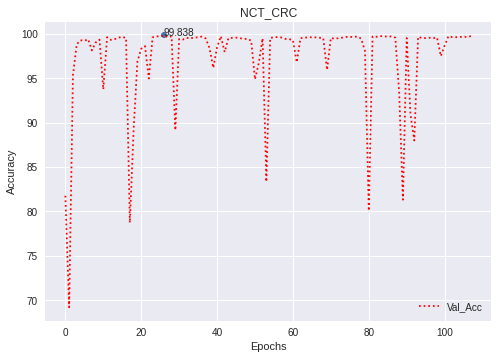

In [18]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

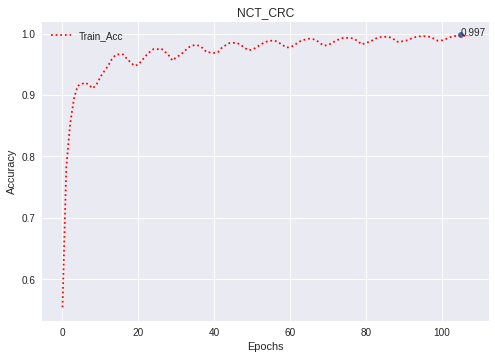

In [19]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

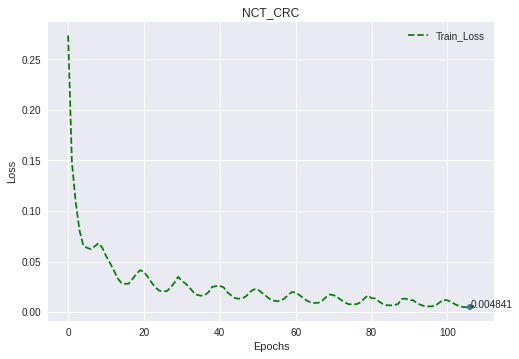

In [20]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [21]:
network.load_state_dict(torch.load(save_PATH))
# test_doc = f"p50/testpng50" 
dict_bat = {}
for k in range(8,65):#20--48
    T_size = k
    print(f"T_size:{k}")
    get_data()

    # for j in range(3):
    test()

    if dict_bat.get(k) is None or dict_bat[k] < test_acc:
            dict_bat[k] = test_acc

T_size:8
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/1250 [00:00<?, ?it/s]

test_Acc:99.86%
Best_eval:[99.86%]
T_size:9
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/1111 [00:00<?, ?it/s]

test_Acc:99.85%
Best_eval:[99.86%]
T_size:10
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/1000 [00:00<?, ?it/s]

test_Acc:99.91%
Best_eval:[99.91%]
T_size:11
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/909 [00:00<?, ?it/s]

test_Acc:99.78%
Best_eval:[99.91%]
T_size:12
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/833 [00:00<?, ?it/s]

test_Acc:99.83%
Best_eval:[99.91%]
T_size:13
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/769 [00:00<?, ?it/s]

test_Acc:99.84%
Best_eval:[99.91%]
T_size:14
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/714 [00:00<?, ?it/s]

test_Acc:99.84%
Best_eval:[99.91%]
T_size:15
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/667 [00:00<?, ?it/s]

test_Acc:99.89%
Best_eval:[99.91%]
T_size:16
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/625 [00:00<?, ?it/s]

test_Acc:99.87%
Best_eval:[99.91%]
T_size:17
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/588 [00:00<?, ?it/s]

test_Acc:99.8%
Best_eval:[99.91%]
T_size:18
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/556 [00:00<?, ?it/s]

test_Acc:99.85%
Best_eval:[99.91%]
T_size:19
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/527 [00:00<?, ?it/s]

test_Acc:99.77%
Best_eval:[99.91%]
T_size:20
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/500 [00:00<?, ?it/s]

test_Acc:99.9%
Best_eval:[99.91%]
T_size:21
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/476 [00:00<?, ?it/s]

test_Acc:99.89%
Best_eval:[99.91%]
T_size:22
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/455 [00:00<?, ?it/s]

test_Acc:99.82%
Best_eval:[99.91%]
T_size:23
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/435 [00:00<?, ?it/s]

test_Acc:99.87%
Best_eval:[99.91%]
T_size:24
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/417 [00:00<?, ?it/s]

test_Acc:99.77%
Best_eval:[99.91%]
T_size:25
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/400 [00:00<?, ?it/s]

test_Acc:99.78%
Best_eval:[99.91%]
T_size:26
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/385 [00:00<?, ?it/s]

test_Acc:99.82%
Best_eval:[99.91%]
T_size:27
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/371 [00:00<?, ?it/s]

test_Acc:99.8%
Best_eval:[99.91%]
T_size:28
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/357 [00:00<?, ?it/s]

test_Acc:99.79%
Best_eval:[99.91%]
T_size:29
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/345 [00:00<?, ?it/s]

test_Acc:99.66%
Best_eval:[99.91%]
T_size:30
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/334 [00:00<?, ?it/s]

test_Acc:99.7%
Best_eval:[99.91%]
T_size:31
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/323 [00:00<?, ?it/s]

test_Acc:99.76%
Best_eval:[99.91%]
T_size:32
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/313 [00:00<?, ?it/s]

test_Acc:99.74%
Best_eval:[99.91%]
T_size:33
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/303 [00:00<?, ?it/s]

test_Acc:99.8%
Best_eval:[99.91%]
T_size:34
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/294 [00:00<?, ?it/s]

test_Acc:99.78%
Best_eval:[99.91%]
T_size:35
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/286 [00:00<?, ?it/s]

test_Acc:99.58%
Best_eval:[99.91%]
T_size:36
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/278 [00:00<?, ?it/s]

test_Acc:99.66%
Best_eval:[99.91%]
T_size:37
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/271 [00:00<?, ?it/s]

test_Acc:99.84%
Best_eval:[99.91%]
T_size:38
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/264 [00:00<?, ?it/s]

test_Acc:99.67%
Best_eval:[99.91%]
T_size:39
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/257 [00:00<?, ?it/s]

test_Acc:99.68%
Best_eval:[99.91%]
T_size:40
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/250 [00:00<?, ?it/s]

test_Acc:99.73%
Best_eval:[99.91%]
T_size:41
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:99.73%
Best_eval:[99.91%]
T_size:42
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:99.76%
Best_eval:[99.91%]
T_size:43
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:99.8%
Best_eval:[99.91%]
T_size:44
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:99.68%
Best_eval:[99.91%]
T_size:45
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:99.75%
Best_eval:[99.91%]
T_size:46
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:99.72%
Best_eval:[99.91%]
T_size:47
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:99.83%
Best_eval:[99.91%]
T_size:48
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:99.46%
Best_eval:[99.91%]
T_size:49
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:99.72%
Best_eval:[99.91%]
T_size:50
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:99.57%
Best_eval:[99.91%]
T_size:51
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:99.61%
Best_eval:[99.91%]
T_size:52
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:99.44%
Best_eval:[99.91%]
T_size:53
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.56%
Best_eval:[99.91%]
T_size:54
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:99.84%
Best_eval:[99.91%]
T_size:55
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:99.43%
Best_eval:[99.91%]
T_size:56
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:99.61%
Best_eval:[99.91%]
T_size:57
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:99.57%
Best_eval:[99.91%]
T_size:58
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.59%
Best_eval:[99.91%]
T_size:59
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:99.41%
Best_eval:[99.91%]
T_size:60
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:99.57%
Best_eval:[99.91%]
T_size:61
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:99.27%
Best_eval:[99.91%]
T_size:62
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:99.66%
Best_eval:[99.91%]
T_size:63
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.68%
Best_eval:[99.91%]
T_size:64
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT_CRC ==> test ...


  0%|          | 0/157 [00:00<?, ?it/s]

test_Acc:99.51%
Best_eval:[99.91%]


In [22]:
show.conclusion(img_title=img_title)
print(sorted(dict_bat.items(), key=lambda x: x[1], reverse=True)[0:9])

=================Conclusion====================
Dataset:[NCT_CRC]
Best_Epoch [3]
[Test] ACC:99.91%.
[(10, 99.90995526313782), (20, 99.89994764328003), (15, 99.88994598388672), (21, 99.88994598388672), (16, 99.86993670463562), (23, 99.86993670463562), (8, 99.85992908477783), (9, 99.84992742538452), (18, 99.84992742538452)]


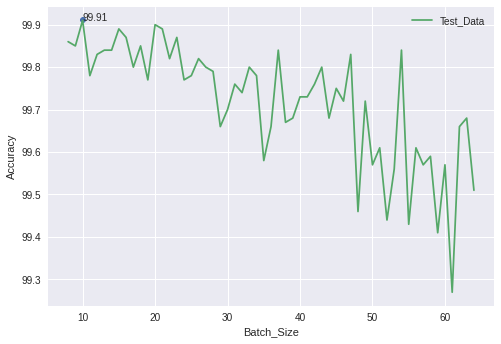

In [23]:
draw_size_acc(dict_bat,custom_path='./tmp',img_title=img_title,suf=suf)

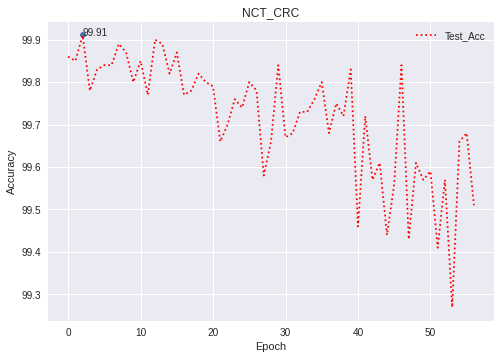

In [24]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

In [25]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
|  ADI   |    1.0    |  1.0   |  1.0  |          |
|  BACK  |    1.0    |  1.0   |  1.0  |          |
|  DEB   |    1.0    |  1.0   |  1.0  |          |
|  LYM   |    1.0    | 0.998  | 0.999 |          |
|  MUC   |   0.9978  | 0.998  | 0.998 |          |
|  MUS   |   0.9985  | 0.999  | 0.999 |          |
|  NORM  |   0.9989  |  1.0   | 0.999 |          |
|  STR   |   0.999   | 0.997  | 0.998 |          |
|  TUM   |   0.9979  | 0.999  | 0.999 |          |
| Total: |           |        |       |  0.9991  |
+--------+-----------+--------+-------+----------+


In [26]:
metrics_scores(val_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
|  ADI   |    1.0    |  1.0   |  1.0  |          |
|  BACK  |    1.0    |  1.0   |  1.0  |          |
|  DEB   |    1.0    | 0.999  |  1.0  |          |
|  LYM   |    1.0    | 0.998  | 0.999 |          |
|  MUC   |   0.9899  |  1.0   | 0.995 |          |
|  MUS   |   0.9985  | 0.996  | 0.997 |          |
|  NORM  |   0.9965  | 0.997  | 0.997 |          |
|  STR   |   0.9981  | 0.996  | 0.997 |          |
|  TUM   |    1.0    | 0.999  |  1.0  |          |
| Total: |           |        |       |  0.9984  |
+--------+-----------+--------+-------+----------+


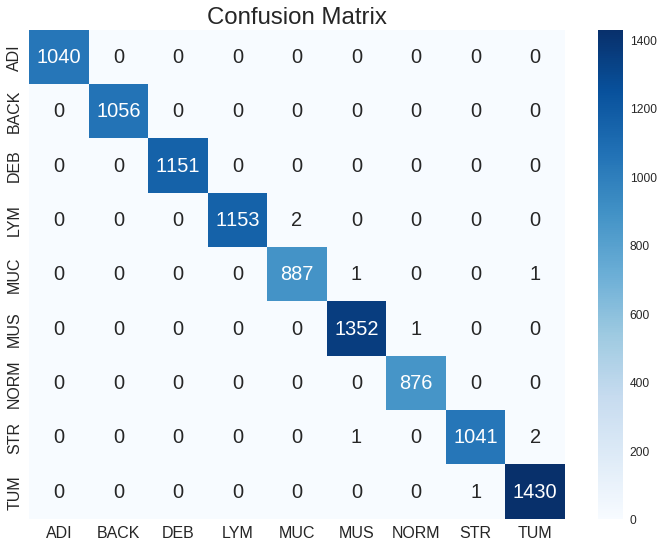

In [27]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [28]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s3 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

In [29]:
torch.cuda.memory.empty_cache()